In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [3]:
target = pd.read_csv('target2',header=None,index_col=0)

In [4]:
################ after all test table ################ CV score: 3.68155 
train = feather.read_dataframe('ensemble\\top_train')
test = feather.read_dataframe('ensemble\\top_test')
#################################################### 3.68088 with merch and city

In [5]:
by_all_purchases = feather.read_dataframe('all_purchases_diff')

In [6]:
train = pd.merge(train,by_all_purchases,on='card_id',how='left')
test = pd.merge(test,by_all_purchases,on='card_id',how='left')

In [7]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in train.columns.values if (re.search('modeplus',x) or re.search('feature_',x))]

In [8]:
warnings.filterwarnings("ignore")
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 150, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.07,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5, #5
             "bagging_fraction": 0.75, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
#             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param, trn_data,10000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.12778	valid_1's rmse: 3.70211
Early stopping, best iteration is:
[108]	training's rmse: 3.34481	valid_1's rmse: 3.68338
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.14072	valid_1's rmse: 3.64794
Early stopping, best iteration is:
[62]	training's rmse: 3.45552	valid_1's rmse: 3.62817
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.13992	valid_1's rmse: 3.62756
Early stopping, best iteration is:
[50]	training's rmse: 3.48764	valid_1's rmse: 3.60666
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.09544	valid_1's rmse: 3.80462
Early stopping, best iteration is:
[53]	training's rmse: 3.43634	valid_1's rmse: 3.7924
fold n°4
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.14466	valid_1's rmse: 3.65049
Early sto

In [9]:
merch_and_city = feather.read_dataframe('merchants_and_city_id\\groupped')

In [10]:
additional_purch_info = feather.read_dataframe('all_purchases_and_last_purch')

In [11]:
merch_mode_cols = ['state_id_min','state_id_max','state_id_add_mode','subsector_id_min','subsector_id_max','subsector_id_add_mode']

In [12]:
train = pd.merge(train,merch_and_city,on='card_id',how='left')
test = pd.merge(test,merch_and_city,on='card_id',how='left')

In [13]:
train = pd.merge(train,additional_purch_info,on='card_id',how='left')
test = pd.merge(test,additional_purch_info,on='card_id',how='left')

In [121]:
if 'best_cols' in locals():
    features = [c for c in best_cols if c not in ['card_id', 'first_active_month','last_active_month']]
else:
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))]

In [122]:
#del best_cols

In [123]:
warnings.filterwarnings("ignore")
outputs = []
ptest = 1
for ptest in range(1):
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 150, #checked
             'min_data_in_leaf': 100, #checked
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.07,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.75, #checked
             "bagging_freq": 5, #5
             "bagging_fraction": 0.75, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked
#            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
             'gpu_use_dp':True,
            }

    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param, trn_data,100000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
    print("CV score: {:<8.5f}".format(errr))
    outputs.append(f'{ptest}, {errr}')
    print(f'\n^ {ptest} - num leaves^ \n')

fold n°0
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.08702	valid_1's rmse: 3.68898
Early stopping, best iteration is:
[62]	training's rmse: 3.4274	valid_1's rmse: 3.67375
fold n°1
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.10112	valid_1's rmse: 3.63897
Early stopping, best iteration is:
[64]	training's rmse: 3.43668	valid_1's rmse: 3.62065
fold n°2
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.10242	valid_1's rmse: 3.61342
Early stopping, best iteration is:
[50]	training's rmse: 3.47074	valid_1's rmse: 3.59708
fold n°3
Training until validation scores don't improve for 200 rounds.
[250]	training's rmse: 3.06865	valid_1's rmse: 3.79897
Early stopping, best iteration is:
[63]	training's rmse: 3.39655	valid_1's rmse: 3.78281
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[44]	training's rmse: 3.48941	

In [126]:
#pd.DataFrame({'cols':best_fit}).to_feather('test_all_addition_best_fit')

In [105]:
#3.66220 #3.78895 #basic

In [ ]:
#3.65985   3.78281

In [118]:
best_cols = best_fit

In [86]:
best_fit = best_cols

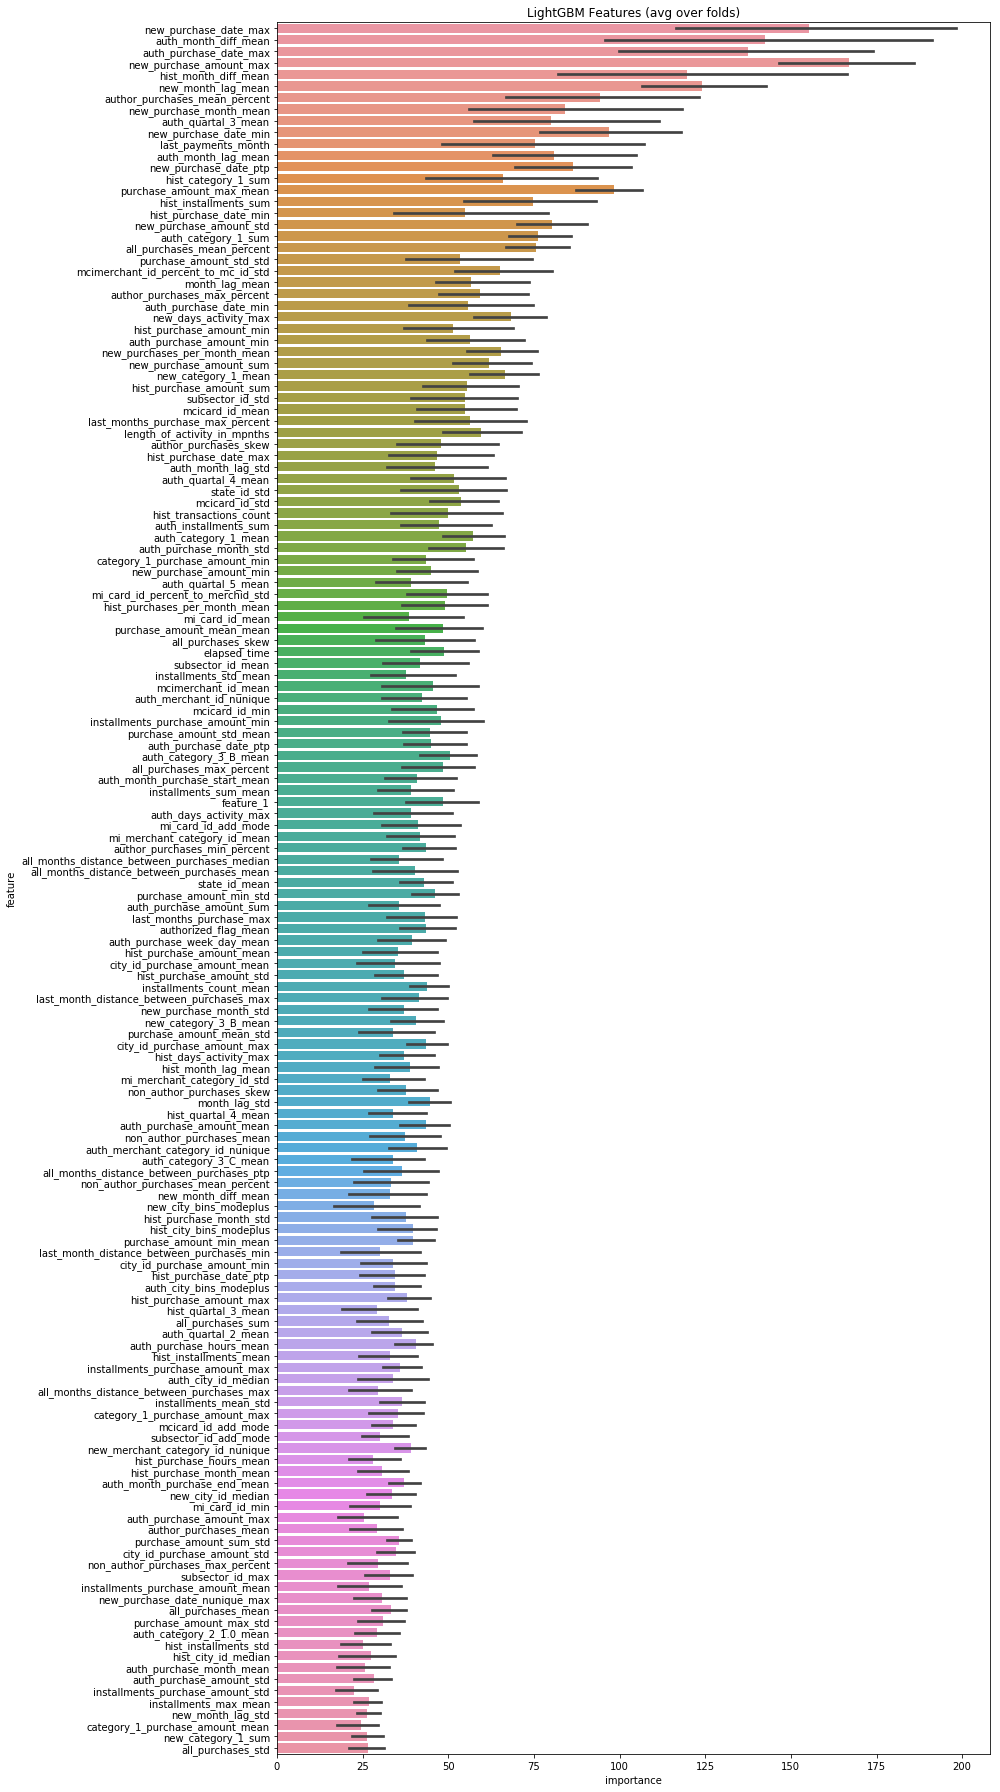

In [119]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [120]:
pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')

,importance
feature,
installments_purchase_amount_std,22.6
category_1_purchase_amount_mean,24.4
hist_installments_std,25.2
auth_purchase_amount_max,25.4
auth_purchase_month_mean,25.6
new_category_1_sum,26.2
new_month_lag_std,26.4
all_purchases_std,26.6
installments_max_mean,26.8


In [112]:
best_cols = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')

In [113]:
best_cols = best_cols[best_cols.importance > 20].index.values

In [114]:
best_cols

array(['hist_installments_mean', 'new_city_id_median',
       'category_1_purchase_amount_max', 'hist_transactions_count',
       'subsector_id_add_mode', 'author_purchases_mean',
       'installments_purchase_amount_std', 'hist_purchase_month_std',
       'installments_max_mean', 'mi_merchant_category_id_std',
       'auth_category_2_1.0_mean', 'installments_purchase_amount_max',
       'installments_std_mean', 'hist_quartal_3_mean',
       'purchase_amount_sum_std', 'auth_purchase_amount_sum',
       'purchase_amount_min_mean', 'purchase_amount_max_std',
       'hist_days_activity_max', 'city_id_purchase_amount_mean',
       'all_purchases_std', 'mi_card_id_min',
       'auth_month_purchase_start_mean',
       'last_month_distance_between_purchases_min',
       'non_author_purchases_max_percent',
       'all_months_distance_between_purchases_max',
       'auth_purchase_amount_max', 'auth_purchase_month_mean',
       'last_month_distance_between_purchases_max', 'new_month_lag_std',
  

In [128]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit.csv", index=False)

In [131]:
train
test

In [132]:
#feather.write_dataframe(train,'merchants_and_city_id\\all_additional_train')
#feather.write_dataframe(test,'merchants_and_city_id\\all_additional_test')

In [133]:
train

,hist_transactions_count,installments_min_std,new_purchase_hours_mean,category_1_purchase_amount_mean,category_1_installments_min,installments_purchase_amount_std,mcimerchant_id_add_mode,category_1_installments_std,new_purchase_date_nunique_max,auth_city_id_nunique,auth_purchase_amount_std,category_1_purchase_amount_std,mi_merchant_category_id_max,installments_max_mean,auth_purchase_amount_max,auth_category_3_C_mean,all_purchases_sum,installments_mean_std,mi_merchant_category_id_std,hist_category_1_mean,hist_merchant_category_id_nunique,auth_installments_mean,all_purchases_std,installments_purchase_amount_mean,installments_purchase_amount_max,last_month_distance_between_purchases_max,auth_city_id_median,last_month_distance_between_purchases_median,new_installments_std,all_purchases_mean,new_city_id_median,city_id_purchase_amount_mean,new_category_1_sum,new_city_bins_modeplus,auth_category_2_1.0_mean,hist_quartal_4_mean,category_1_purchase_amount_max,hist_purchase_date_ptp,author_purchases_mean,hist_category_3_B_mean,auth_purchase_month_mean,auth_month_purchase_end_mean,hist_purchase_month_std,purchase_amount_sum_std,subsector_id_add_mode,hist_quartal_3_mean,new_purchase_month_max,purchase_amount_sum_mean,all_months_distance_between_purchases_min,hist_installments_mean,city_id_purchase_amount_std,all_months_distance_between_purchases_ptp,last_month_distance_between_purchases_ptp,all_purchases_min_percent,hist_purchase_month_mean,last_month_distance_between_purchases_min,mi_card_id_min,new_month_lag_std,non_author_purchases_max_percent,all_months_distance_between_purchases_max,hist_city_id_median,purchase_amount_min_mean,installments_sum_std,mcicard_id_add_mode,subsector_id_max,installments_std_mean,installments_std_std,auth_quartal_5_mean,auth_quartal_2_mean,new_merchant_category_id_nunique,non_author_purchases_skew,mi_merchant_category_id_mean,purchase_amount_max_std,hist_purchase_hours_mean,hist_purchase_date_nunique_max,auth_month_purchase_start_mean,hist_city_bins_modeplus,city_id_purchase_amount_min,auth_installments_sum,hist_month_lag_std,last_months_purchase_max,purchase_amount_mean_std,hist_purchase_amount_mean,mcimerchant_id_mean,installments_sum_mean,hist_purchase_amount_max,new_month_diff_mean,hist_days_activity_max,state_id_mean,all_months_distance_between_purchases_mean,non_author_purchases_mean_percent,all_months_distance_between_purchases_median,auth_days_activity_max,auth_city_bins_modeplus,auth_purchase_amount_sum,new_category_3_B_mean,purchase_amount_min_std,hist_installments_std,new_purchase_month_std,auth_merchant_category_id_nunique,author_purchases_min_percent,all_purchases_skew,non_author_purchases_mean,auth_purchase_hours_mean,auth_category_3_B_mean,city_id_purchase_amount_max,hist_month_lag_mean,purchase_amount_std_mean,mi_card_id_add_mode,installments_count_mean,new_purchase_amount_sum,hist_purchases_per_month_mean,new_purchase_amount_min,elapsed_time,auth_purchase_week_day_mean,hist_purchase_amount_std,category_1_purchase_amount_min,month_lag_std,purchase_amount_mean_mean,mi_card_id_mean,subsector_id_mean,auth_purchase_amount_mean,auth_month_lag_std,auth_quartal_4_mean,auth_purchase_date_ptp,auth_merchant_id_nunique,purchase_amount_std_std,feature_1,mi_card_id_percent_to_merchid_std,hist_purchase_amount_min,author_purchases_skew,mcicard_id_min,auth_purchase_month_std,author_purchases_max_percent,auth_purchase_amount_min,authorized_flag_mean,installments_purchase_amount_min,all_purchases_max_percent,hist_purchase_amount_sum,mcicard_id_mean,hist_purchase_date_max,month_lag_mean,hist_purchase_date_min,new_days_activity_max,subsector_id_std,new_purchases_per_month_mean,hist_installments_sum,length_of_activity_in_mpnths,new_category_1_mean,last_months_purchase_max_percent,mcimerchant_id_percent_to_mc_id_std,auth_purchase_date_min,auth_month_lag_mean,auth_category_1_mean,state_id_std,mcicard_id_std,hist_category_1_sum,last_payments_month,new_purchase_amount_std,all_purchases_mean_percent,auth_category_1_sum